# 1. Identifying fraudulent claims

You have a project with a new customer who has asked you to find a way to prioritize suspicious claims on the motor line of business, in order to help the investigators of the company on their daily work.

You have already started the project with the customer and after some initial meetings it has been possible to identify what data is needed and what data is available. Finally they have delivered to you the data in a csv file called claims.csv.



# 2. Data

The data that you will find here has the following information

|| |||
| --- ||||
| monthsascustomer | age | policy_number | policybinddate |
| policy_state | policy_csl | policy_deductable | policyannualpremium |
| umbrella_limit | insured_zip | insured_sex | insurededucationlevel |
| insured_occupation | insured_hobbies | insured_relationship | capital-gains |
| capital-loss | incident_date | incident_type | collision_type |
| incident_severity | authorities_contacted | incident_state | incident_city |
| incident_location | incidenthouroftheday | numberofvehicles_involved | property_damage |
| bodily_injuries | witnesses | policereportavailable | totalclaimamount |
| injury_claim | property_claim | vehicle_claim | auto_make |
| auto_model | auto_year | fraud_reported | _c39] |

# 3. Solution

Now is your turn. In the next step you need to develop a prototype with this data and show the customer your results and try to convince them that your model will offer an added value to the company. Good luck!!

In [58]:
import pandas as pd
from IPython.display import display, Markdown as md
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from collections import Counter
import math
from scipy import stats
from collections import defaultdict
from sklearn import preprocessing, model_selection, linear_model, metrics, ensemble, feature_selection

In [59]:
INPUT_FILE = "claims.csv"
df = pd.read_csv(INPUT_FILE)
y_name = "fraud_reported"
num_samples = len(df.index)

## 3.1 Missing values

What is the percentage of missing values in each column?

In [60]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
_c39,700,1.0
age,0,0.0
incident_state,0,0.0
incident_city,0,0.0
incident_location,0,0.0
incident_hour_of_the_day,0,0.0
number_of_vehicles_involved,0,0.0
property_damage,0,0.0
bodily_injuries,0,0.0
witnesses,0,0.0


We observe that only one column has 100% missing values and can be dropped. 

In [61]:
columns_to_drop = (missing_data[missing_data['Total'] > 10]).index
df = df.drop(columns_to_drop, axis=1)

## 3.2 Variable modifications

For each variable, we display the (max 10) most frequent values in [value, frequency] format.<br/>
It may be necessary to drop or modify columns.

After reviewing the display below, we decide to:

Drop the following columns:
- `policy_number`: since it constitutes an ID
- `incident_location`: the incident may have happened at the same address in a different city or US state 
- `insured_zip`: there is a different ZIP for each sample; we are already using different geographical information (state, city)
- `policy_bind_date`, `incident_date`: replaced by `insurance_duration`

Turn several variables from categorical to numerical, because there is information in the order :
- `policy_csl`: {100/300, 250/500, 500/1000}, it makes more sense as a numerical variable {0,1,2}
- `incident_severity`: {Trivial/Minor/Major Damage, Total Loss} $\rightarrow$ {0,1,2,3}
- `police_report_available`: NO=0, ?=1, YES=2
- `property_damage`: NO=0, ?=1, YES=2

Create the following columns:
- `insurance_duration`: it replaces the variables `policy_bind_date` and `incident_date` with their difference, in days

In [62]:
for c in df.columns:
    vc = df[c].value_counts(ascending=False).iloc[0:10]
    display(pd.DataFrame(vc))

,months_as_customer
289,6
259,6
230,6
210,6
140,6
285,5
107,5
128,5
156,5
245,5


,age
34,37
43,33
33,32
41,31
39,29
31,29
32,28
30,28
37,27
38,26


,policy_number
125591,1
836349,1
130930,1
413192,1
226725,1
533941,1
349658,1
756870,1
942106,1
432740,1


,policy_bind_date
2002-07-16,2
1997-02-03,2
1992-08-05,2
1995-09-19,2
2008-05-16,2
2002-12-28,2
1991-07-20,2
1995-12-07,2
1999-12-07,2
2006-01-01,2


,policy_state
OH,249
IL,237
IN,214


,policy_csl
100/300,259
250/500,248
500/1000,193


,policy_deductable
1000,250
500,231
2000,219


,policy_annual_premium
1281.25,2
1362.87,2
1389.13,2
1074.07,2
1073.83,2
1558.29,2
1453.61,1
1618.65,1
1927.87,1
1135.43,1


,umbrella_limit
0,557
6000000,38
5000000,34
4000000,28
7000000,21
3000000,8
8000000,7
2000000,3
9000000,2
10000000,1


,insured_zip
431202,2
450947,1
455689,1
607605,1
605408,1
475407,1
609317,1
442604,1
453193,1
445120,1


,insured_sex
FEMALE,370
MALE,330


,insured_education_level
JD,120
High School,105
Associate,105
Masters,99
MD,93
College,91
PhD,87


,insured_occupation
machine-op-inspct,66
exec-managerial,57
craft-repair,54
sales,54
prof-specialty,53
priv-house-serv,52
armed-forces,51
transport-moving,50
tech-support,50
other-service,47


,insured_hobbies
exercise,45
bungie-jumping,44
golf,42
movies,41
polo,41
paintball,40
kayaking,38
yachting,38
reading,38
camping,38


,insured_relationship
own-child,130
other-relative,126
husband,125
not-in-family,123
wife,105
unmarried,91


,capital-gains
0,347
51500,4
46300,4
51400,3
46700,3
38600,3
37900,3
59600,3
63600,3
67800,3


,capital-loss
0,343
-31400,4
-61400,4
-51000,4
-53800,4
-49400,3
-49200,3
-50300,3
-50000,3
-45800,3


,incident_date
2015-02-02,21
2015-01-24,17
2015-01-07,17
2015-02-04,17
2015-02-17,16
2015-01-21,16
2015-01-08,16
2015-02-23,16
2015-01-19,16
2015-01-09,15


,incident_type
Multi-vehicle Collision,302
Single Vehicle Collision,275
Vehicle Theft,68
Parked Car,55


,collision_type
Rear Collision,208
Side Collision,194
Front Collision,175
?,123


,incident_severity
Minor Damage,237
Major Damage,200
Total Loss,199
Trivial Damage,64


,authorities_contacted
Police,199
Fire,153
Ambulance,145
Other,143
None,60


,incident_state
NY,187
SC,178
WV,149
NC,78
VA,69
PA,21
OH,18


,incident_city
Springfield,117
Arlington,110
Columbus,108
Northbend,96
Hillsdale,96
Riverwood,90
Northbrook,83


,incident_location
7082 Oak Ridge,1
5663 Oak Lane,1
2376 Sky Ridge,1
3900 Texas St,1
8809 Flute St,1
2651 MLK Lane,1
6260 5th Lane,1
9633 MLK Lane,1
3799 Embaracadero Drive,1
3246 Britain Ridge,1


,incident_hour_of_the_day
17,38
3,36
23,36
4,35
0,35
16,35
13,34
10,32
14,31
21,31


,number_of_vehicles_involved
1,398
3,251
4,28
2,23


,property_damage
?,259
NO,223
YES,218


,bodily_injuries
0,236
2,232
1,232


,witnesses
1,181
0,177
2,173
3,169


,police_report_available
?,247
NO,236
YES,217


,total_claim_amount
75400,4
2640,4
57700,3
77440,3
4320,3
79800,3
46200,3
84590,3
4950,3
58300,3


,injury_claim
0,19
480,7
780,5
640,5
900,4
860,4
5540,4
680,4
9880,3
13520,3


,property_claim
0,14
480,4
640,4
11080,4
860,4
660,4
680,4
840,4
6620,4
8400,3


,vehicle_claim
5040,6
44800,5
3600,5
33600,5
3360,4
25200,3
2940,3
46000,3
4340,3
4720,3


,auto_make
Suburu,57
Nissan,56
Saab,56
Toyota,55
Chevrolet,54
Volkswagen,54
Audi,51
Ford,49
Dodge,49
BMW,48


,auto_model
Wrangler,31
RAM,29
A3,28
Passat,28
Jetta,26
A5,23
Legacy,23
Pathfinder,23
MDX,23
Forrestor,22


,auto_year
1995,42
2002,41
2009,40
2006,38
2005,38
2003,36
2013,36
1999,36
2000,35
2011,34


,fraud_reported
0,519
1,181


In [63]:
def modify_columns(df):
    df_1 = df.drop(["policy_number", "incident_location", "insured_zip"], axis=1)

    df_1 = df_1.replace({"policy_csl": {"100/300": 0, "250/500": 1, "500/1000": 2},
                         "incident_severity": {"Trivial Damage": 0, "Minor Damage": 1, "Major Damage": 2, "Total Loss": 3},
                         "police_report_available": {"NO": 0, "?": 1, "YES": 2},
                         "property_damage": {"NO": 0, "?": 1, "YES": 2}})

    a = pd.to_datetime(df["incident_date"], yearfirst=True)
    b = pd.to_datetime(df["policy_bind_date"], yearfirst=True)
    policy_time = a - b
    df_1["insurance_duration"] = policy_time.dt.days
    df_1 = df_1.drop(["incident_date", "policy_bind_date"], axis=1)

    return df_1

df = modify_columns(df)

## 3.3 Numerical variables

**Correlation with target variable**

Computing the correlation between the input variables and target variable provides information on a variable's relevance. <br/>
We use the Spearman correlation instead of Pearson's, to cover the case of a non-linear relationship between variables.

We observe that in other datasets (e.g. house prices from Kaggle) the correlation with the target variable is higher, with the most correlated variables having C$\approx$0.75 instead of C$\approx$0.14. <br/>
This indicates that only *combinations* of input variables have a measurable impact on the target variable `fraud_reported`, rather than any one input variable.

We still use correlation as a way to filter out part of the numerical variables, namely those with C<0.02.

In [64]:
def select_highcorr_numvars(dataframe, cutoff, printout):
    # Find most important features relative to target
    numerical_vars = dataframe.select_dtypes(include=np.number).columns.tolist()
    df_1 = dataframe[numerical_vars]

    corr = df_1.corr(method='spearman')
    corr.sort_values([y_name], ascending=False, inplace=True)
    print(corr[y_name].to_string(name=False))

    relevant_vars =   [v for v in numerical_vars if abs(corr[y_name][v]) >= cutoff]
    relevant_vars.remove(y_name)
    vars_to_exclude = [v for v in numerical_vars if abs(corr[y_name][v]) < cutoff]
    
    if printout:
        print("\n" + str(len(vars_to_exclude)) + " variables dropped: " + str(vars_to_exclude))
        print("\n" + str(len(relevant_vars)) + " variables kept: " + str(relevant_vars))
    return dataframe.drop(vars_to_exclude, axis=1), corr, relevant_vars

df, corr, relevant_vars = select_highcorr_numvars(df, cutoff=0.02, printout=True)

fraud_reported                 1.000000
vehicle_claim                  0.142668
total_claim_amount             0.135830
incident_severity              0.125348
property_claim                 0.109286
injury_claim                   0.079860
witnesses                      0.073019
number_of_vehicles_involved    0.070372
property_damage                0.062993
umbrella_limit                 0.040850
policy_deductable              0.040671
bodily_injuries                0.024045
insurance_duration             0.021668
auto_year                      0.020425
incident_hour_of_the_day       0.014262
policy_annual_premium          0.000880
months_as_customer            -0.007532
police_report_available       -0.012268
capital-loss                  -0.017945
policy_csl                    -0.019269
age                           -0.021035
capital-gains                 -0.044315

6 variables dropped: ['months_as_customer', 'policy_csl', 'policy_annual_premium', 'capital-loss', 'incident_hour_of_th

**Collinearity between input variables**

In datasets, if two or more input variables are very highly correlated (e.g. C>0.8) then they carry nearly the same information, so it is opportune to keep only one.

Perfect collinearity is reached when one variable can be obtained as a linear combination of the other: <br/>
Given 2 input variables X1 and X2, $ \quad \forall i ( X1_i = \lambda_a X0_i + \lambda_b ) \quad \Rightarrow \quad correlation(X1_i, X2_i) = \pm 1$.

Visualizing correlation values in the heatmap below, we find that `injury_claim`, `property_claim`, and `vehicle_claim` are highly correlated to `total_claim_amount`. We decide to keep only `total_claim_amount`.

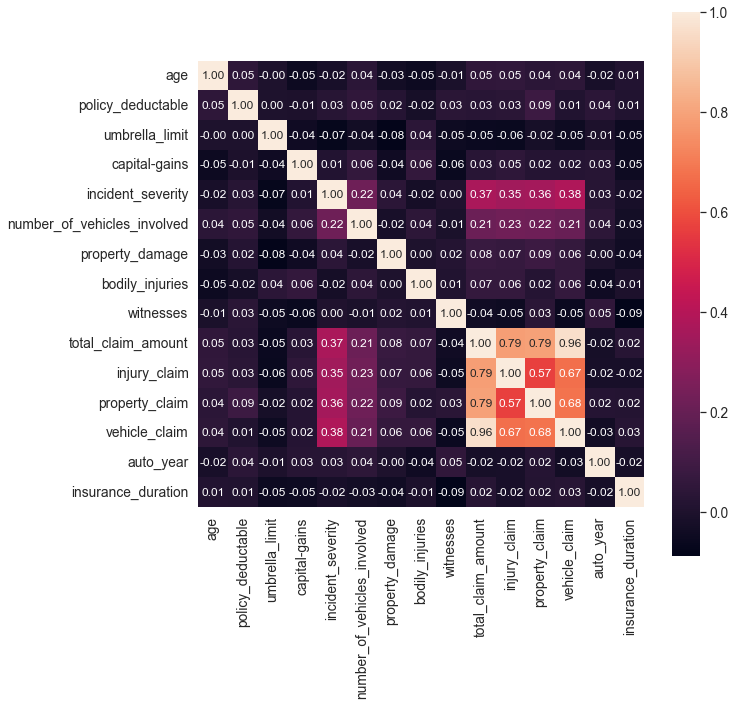

In [65]:
def drop_multicollinear(corr, df, show_figure):
    corr = corr[relevant_vars].loc[relevant_vars]

    if show_figure:
        f, ax = plt.subplots(figsize=(10, 10))
        sns.set(font_scale=1.25)
        ax = sns.heatmap(corr, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, 
                         xticklabels=corr.index, yticklabels=corr.index)
        plt.savefig(os.path.join("Correlation_matrix.png"))
        img = mpimg.imread(os.path.join("Correlation_matrix.png"))
    return df.drop(["injury_claim", "property_claim", "vehicle_claim"], axis=1)
    
    
df = drop_multicollinear(corr, df, show_figure=True)

**Outliers**

Before addressing scaling, it is sensible to detect and remove outliers.

Outliers can be found using either:
- the inter-quartile range (IQR): a data point $x_i$ is an outlier if $x_i \lt Q1 – \frac{3}{2} \text{IQR}$ or $x_i \gt Q3 – \frac{3}{2} \text{IQR}$
- the standard deviation: $x_i$ is an outlier if it falls outside of $\mu \pm 3\cdot \sigma$. The data should follow a normal distribution

As seen later, most columns do not follow a normal distribution, so outliers are found using the IQR.

In the variable `umbrella_limit`, more than half the values are =0 and the rest are $\approx 10^6$.<br/>
We deal with it by transforming it into a binary variable, with the assignment $x_i>0 \rightarrow x_i=1$.

The IQR check highlights only 1 other outlier, in `total_claim_amount`. We replace outliers with the closest quartile (1st or 3rd)

In [66]:
def adjust_outliers(df):
    numerical_vars = df.select_dtypes(include=np.number).columns.tolist()
    df_1 = df.copy(deep=True)
    qs_dict = dict()

    for nv in numerical_vars:
        values = df_1[nv].tolist()
        values.sort()  # default: ascending
        q1 = values[int(num_samples*0.25)]
        median = values[int(num_samples*0.5)]
        q3 = values[int(num_samples*0.75)]
        # print("\nVariable: " + nv)
        # print("Q1=" + str(q1) + " ; " + "Q3=" + str(q3) + " ; " + "IQR=" + str(q3-q1))
        qs_dict[nv] = (q1, q3)

    for i, row in df_1.iterrows():
        for nv in numerical_vars:
            val = row[nv]
            q1 = qs_dict[nv][0]
            q3 = qs_dict[nv][1]
            iqr = q3 - q1
            if q1!=q3:  # to deal separately with `umbrella_limit`
                if val < q1 - 1.5*iqr: 
                    print("Variable:" + nv + "; found outlier=" + str(val) + " ; replacing with Q1=" + str(q1))
                    df.at[i, nv] = q1
                if val > q3 + 1.5*iqr: 
                    print("Variable:" + nv + "; found outlier=" + str(val) + " ; replacing with Q3=" + str(q3))
                    df.at[i, nv] = q3

            if nv=="umbrella_limit":
                df.at[i, nv] = 1 if df_1.at[i, nv]>0 else 0
        
adjust_outliers(df)

Variable:total_claim_amount; found outlier=114920 ; replacing with Q3=70290


**Distribution and scaling**

The distribution of the numerical variables is visualized in the frequency histograms below.<br/>
Do the variables follow a normal distribution? Taking into account that some variables are discrete with a few possible values (e.g. witnesses), we observe the following:

- `age`: skewed
- `policy_deductable`: quasi-normal, high kurtosis
- `umbrella_limity`: peak at 0
- `capital-gains`: peak at 0
- `incident_severity`: skewed
- `number_of_vehicles_involved`: peak at 1
- `property damage`: quasi-normal, high kurtosis
- `bodily_injuries`: nearly uniform
- `witnesses`: nearly uniform
- `total_claim_amount`: peak at 0
- `auto_year`: nearly uniform
- `insurance_duration`: nearly uniform

Since the variables do not follow normal distribution, the choice of scaling method is not obvious. <br/>
**Standardization**: $\left(\frac{x-\mu}{\sigma}\right)$ is usually applied to variables that are approximately normal to bring them on a standard normal curve $N(\mu=0,\sigma=1)$. While applying it is still possible, the resulting data won't be normal.
<br/>
**MinMaxScaler** can be used to bring the data in the range [0,1]. <br/>
**RobustScaler**: $\frac{x_i - \text{median}}{\text{IQR}}$. It does not bring the data in a fixed range, but is robust to outliers.

Later, we evaluate how the performance of models differs depending on the choice of scaling method.

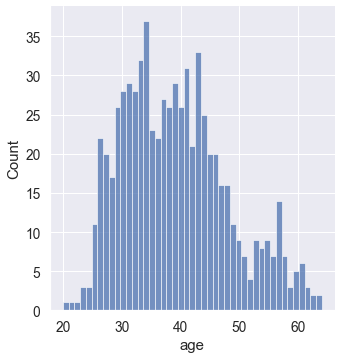

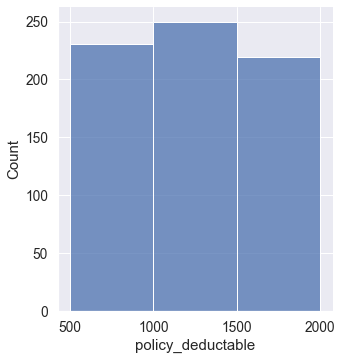

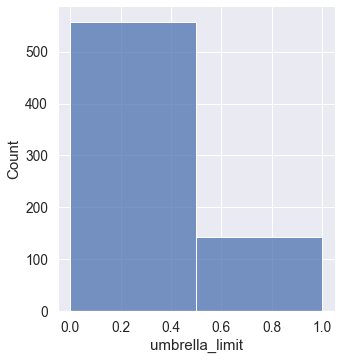

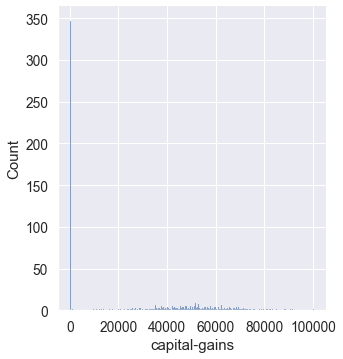

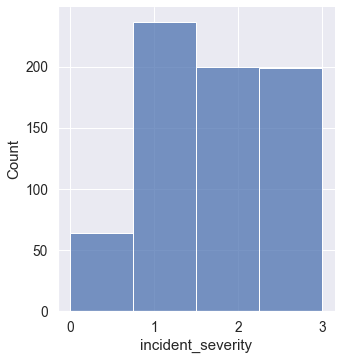

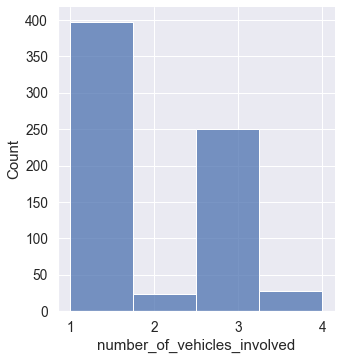

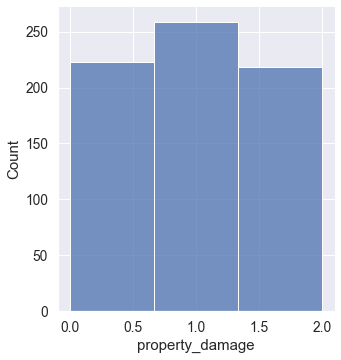

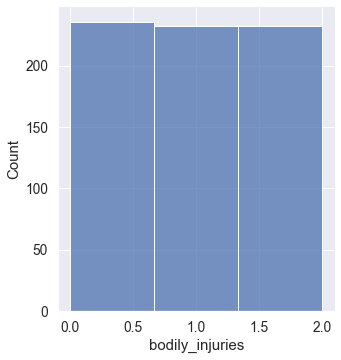

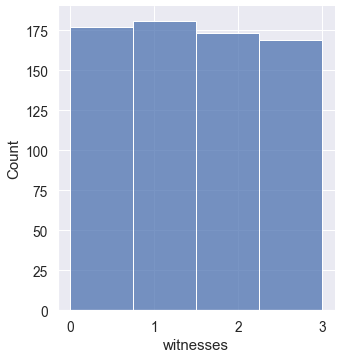

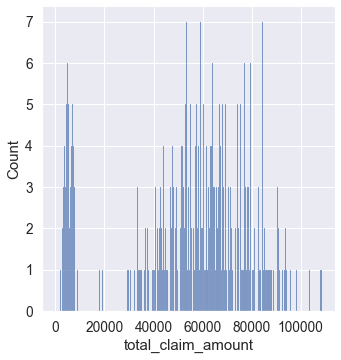

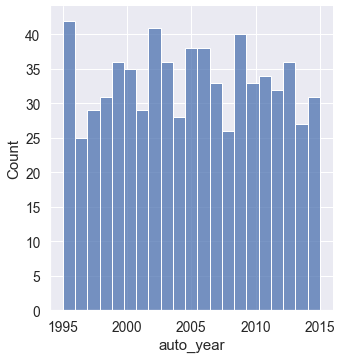

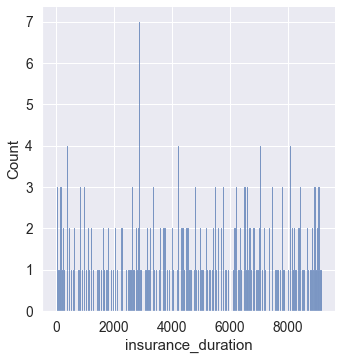

In [67]:
hist_nested_dict = defaultdict(dict)
# In order to represent the variable distribution in a histogram,
# initialize a dictionary that stores the values of the input variable and the target variable
for i,row in df.iterrows():
    for v in numerical_vars:
        if not v==y_name:
            try:
                hist_nested_dict[v]["x"].append(row[v])
                hist_nested_dict[v]["y"].append(row[y_name])
            except KeyError:
                hist_nested_dict[v]["x"] = [row[v]]
                hist_nested_dict[v]["y"] = [row[y_name]]

                
for col_key in hist_nested_dict.keys():
    try:
        x = hist_nested_dict[col_key]["x"]
        hist = sns.displot(data=df, x=hist_nested_dict[col_key]["x"], kind="hist", bins=len(set(x)))
        hist.set(xlabel=col_key)
    except (ValueError, TypeError) as e:
        print("Variable: " + col_key)
        print(e)

## 3.4 Categorical variables

Categorical variables are going to be one-hot-encoded, causing an expansion of the number of features. We wish to exclude variables that have too many categories for too little information gain. Thus, we examine two characteristics for each categorical variable:
- the number of categories
- the strength of the association with the target variable, using the Mutual Information coefficient and Cramer's V

The Mutual Information coefficient evaluates the difference between the joint distribution of the pair P(X,Y) and the product of the distributions P(X) and P(Y).
For a discrete distribution, $I(X,Y) = \sum_{x \in X}\sum_{y \in Y}  P_{X,Y}(x, y) \cdot \log \frac{P_{X,Y}(x, y)}{P_{X}(x)\cdot P_{Y}(y)}$

The Chi-Square test of independence measures the association between discrete variables. Cramer's V is based on the Chi-square statistic as follows: <br/>
$ V = \sqrt{ \frac{max((\chi^2 / n) - b, 0)}{min(\text{rows}-1, \text{columns}-1)} }$ , with a bias correction term for the number of categories $b = \frac{(\text{rows}-1) \cdot (\text{columns}-1)}{n-1}$<br/>

The mutual information values are very low (<=0.06), underlining what we discovered when evaluating the numerical variables' correlation with the target: that there is no strong association of any single variable with the target, and the prediction must be based on a combination of variables.

Nevertheless we need a criterion to select categorical features: we base it on the value of Cramer's V (e.g. >0.1) and the number of categories (e.g. <10, <20)

In [68]:
def cramer_v(x, y):
    dataset = pd.crosstab(index=x, columns=y)
    rows = dataset.shape[0]
    cols = dataset.shape[1]
    X2 = stats.chi2_contingency(dataset, correction=False)[0]
    N = len(x.index)
    minimum_dimension = min(rows, cols)-1
    bias_correction = (rows -1)*(cols -1) / (N-1)
    # Calculate Cramer's V
    result = np.sqrt(max(0,(X2/N - bias_correction)) / minimum_dimension)
    return result


labelenc = preprocessing.LabelEncoder()

def mutual_info(x_str,y):
    x = labelenc.fit_transform(x_str).reshape(-1, 1)
    return feature_selection.mutual_info_classif(x, y)

In [69]:
categorical_variables = []
for c in df.columns:
    if df[c].dtype == pd.CategoricalDtype: 
            categorical_variables.append(c)

lts = []
for c in categorical_variables:
        u = cramer_v(df[c], df[y_name])
        mi = mutual_info(df[c], df[y_name])[0]
        lts.append((c, df[c].value_counts().count(), u, mi))
lts = sorted(lts, key=lambda tpl: tpl[2], reverse=True)
c_info_df = pd.DataFrame(lts, columns=["Variable", "N. unique values",  "Cramer's V", "Mutual Information",])
display(c_info_df)

,Variable,N. unique values,Cramer's V,Mutual Information
0,insured_hobbies,20,0.376981,0.045739
1,collision_type,4,0.171729,0.012405
2,incident_type,4,0.158743,0.013053
3,authorities_contacted,5,0.156514,0.000000
4,incident_state,7,0.116404,0.003103
5,auto_model,39,0.074329,0.011304
6,policy_state,3,0.000000,0.004233
7,insured_sex,2,0.000000,0.018313
8,insured_education_level,7,0.000000,0.000000
9,insured_occupation,14,0.000000,0.002916


In [70]:
def filter_catvars(max_categories, v_cutoff): 
    cat_variables_to_drop = []
    for i,row in c_info_df.iterrows():
        v = row["Variable"]
        num_categories = row["N. unique values"]
        v_coeff = row["Cramer's V"]
        if (num_categories > max_categories) or (v_coeff < v_cutoff):
            cat_variables_to_drop.append(v)
    print("Dropping: " + str(cat_variables_to_drop))
    return df.drop(cat_variables_to_drop, axis=1)

In [72]:
df

,age,policy_state,policy_deductable,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,...,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,total_claim_amount,auto_make,auto_model,auto_year,fraud_reported,insurance_duration
0,37,IN,1000,1,FEMALE,Masters,protective-serv,reading,not-in-family,60100,...,1,1,0,3,57700,Nissan,Maxima,2000,0,526
1,44,IL,500,0,MALE,JD,craft-repair,polo,other-relative,33200,...,3,1,2,1,51400,Honda,Civic,1996,0,6242
2,33,IL,1000,0,FEMALE,High School,machine-op-inspct,skydiving,wife,0,...,1,1,2,1,46800,Jeep,Wrangler,2002,0,6945
3,42,OH,500,0,MALE,JD,transport-moving,video-games,own-child,0,...,3,2,2,2,68520,Suburu,Legacy,2003,1,2292
4,30,OH,1000,0,FEMALE,MD,craft-repair,video-games,own-child,72400,...,3,2,2,1,58960,Ford,F150,2004,0,4821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,37,IN,500,0,MALE,JD,tech-support,video-games,wife,48500,...,1,1,0,3,60170,Nissan,Pathfinder,2011,1,6374
696,43,OH,500,1,MALE,College,machine-op-inspct,golf,husband,0,...,3,0,0,1,70600,Volkswagen,Passat,2013,1,4995
697,37,IN,500,0,FEMALE,College,transport-moving,golf,not-in-family,0,...,3,0,2,0,57120,Mercedes,C300,2002,0,4440
698,44,IL,2000,0,FEMALE,Associate,machine-op-inspct,paintball,other-relative,47200,...,3,1,1,0,35900,Audi,A3,2007,1,4231


## 3.5 Model training and evaluation

The target variable is `fraud_reported`, which can assume a value in {0,1}.

It is necessary to keep some data out of the training set, to check whether the model is able to generalize to unseen data.

The test set will have the same proportion of fraudulent vs. genuine claims as the whole dataset, using sklearn's stratified train-test split.

We run experiments with different models and parameters:
- logistic regression
- Support Vector Machine
- random forest


Scaling alternatives:
- Standardization to ($\mu=0, \sigma=1$)
- MinMaxScaler to [0,1]
- RobustScaler via $ \frac{x-\text{median}}{\text{IQR}} $


Thresholds for feature selection:
- numerical features, cut-off on correlation to target: {0.02, 0.05, 0.01}
- categorical features
    - cut-off on Cramer's V: {0.1, 0.2, 0}
    - cut-off on number of categories: {20, 10}

In [73]:
def preprocess(min_corr, max_categories, min_V):
    # Main pipeline function
    df = pd.read_csv(INPUT_FILE)
    columns_to_drop = (missing_data[missing_data['Total'] > 10]).index
    df = df.drop(columns_to_drop, axis=1)
    
    df = modify_columns(df)
    df, corr, relevant_vars = select_highcorr_numvars(df, cutoff=min_corr, printout=False)
    df = drop_multicollinear(df, show_figure=False)
    adjust_outliers(df)
    
    df = pd.get_dummies(df, columns=cat_variables_to_encode)
    df = filter_catvars(max_categories, min_V)
    
    return df


def get_splits():
    y = df[y_name].copy()
    X = df.drop(y_name, axis=1)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                        stratify=y, 
                                                        test_size=0.1)
    return X_train, X_test, y_train, y_test


def get_metrics(y_true, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    acc = metrics.recall_score(y_true, y_pred, average=None)
    f1 = metrics.f1_score(y_true, y_pred, average=None)
    return confusion_matrix, acc, f1


def train_and_eval(model):
    model.fit(X_train, y_train)
    # model_selection.cross_val_score(model_logreg, X_train, y_train, cv = 5)
    y_pred_test = model.predict(X_test)
    return get_metrics(y_test, y_pred_test)

**Logistic regression**

In [74]:
df = preprocess(min_corr=0.02, max_categories=20, min_V=0.1)
df

fraud_reported                 1.000000
vehicle_claim                  0.142668
total_claim_amount             0.135830
incident_severity              0.125348
property_claim                 0.109286
injury_claim                   0.079860
witnesses                      0.073019
number_of_vehicles_involved    0.070372
property_damage                0.062993
umbrella_limit                 0.040850
policy_deductable              0.040671
bodily_injuries                0.024045
insurance_duration             0.021668
auto_year                      0.020425
incident_hour_of_the_day       0.014262
policy_annual_premium          0.000880
months_as_customer            -0.007532
police_report_available       -0.012268
capital-loss                  -0.017945
policy_csl                    -0.019269
age                           -0.021035
capital-gains                 -0.044315

6 variables dropped: ['months_as_customer', 'policy_csl', 'policy_annual_premium', 'capital-loss', 'incident_hour_of_th

TypeError: drop_multicollinear() missing 2 required positional arguments: 'df' and 'show_figure'

In [46]:
model_logreg = linear_model.LogisticRegression(class_weight='balanced')
train_and_eval(model_logreg)

NameError: name 'train_and_eval' is not defined

**Support Vector Machine**

**Random forest**

## 3.6 Conclusions